In [2]:

from pathlib import Path
import matplotlib.pyplot as plt
import lightning as L
import torch
import torch.nn as nn
from lit_llama import model
import random
from lit_llama import LLaMA, Tokenizer
from lit_llama.utils import EmptyInitOnDevice, lazy_load, llama_model_lookup

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
fabric = L.Fabric(devices=1)
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")
tokenizer = Tokenizer(tokenizer_path)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [4]:
import json
with open('datasets/alpaca_data_cleaned.json') as f:
    alpaca_json = json.load(f)

# Create tokenized j
alpaca_json_tokens = []

for item in alpaca_json:
    alpaca_json_tokens.append(
        {
            'instruction': tokenizer.encode(item['instruction'], bos=True, eos=False, device=fabric.device),
            'input': tokenizer.encode(item['input'], bos=False, eos=False, device=fabric.device),
            'output':tokenizer.encode(item['output'], bos=False, eos=True, device=fabric.device)
        }
    )

In [5]:
def get_batch(batch_size=10):
    batch_indices = random.sample(range(len(alpaca_json_tokens)), k=batch_size)
    batch_indices=[1]
    
    # IST tokens
    IST_tokens = []
    for index in batch_indices:
        llama_input = torch.cat([alpaca_json_tokens[index]['instruction'], alpaca_json_tokens[index]['input']]).unsqueeze(0)
        IST_tokens.append(IST_generator(LLamaModel(llama_input)[1])[:,-1,:])

    # get shortest
    shortest_output_len = 1000
    for item in batch_indices:
        if(len(alpaca_json_tokens[item]['output']) < shortest_output_len):
            shortest_output_len = len(alpaca_json_tokens[item]['output'])


    length = random.randint(0,shortest_output_len-1)
    inputs = []
    targets = []

    for item in batch_indices:
        inputs.append(alpaca_json_tokens[item]['output'][:length])
        targets.append(alpaca_json_tokens[item]['output'][:length+1])
    
    return torch.stack(inputs), torch.stack(targets), torch.stack(IST_tokens)


In [6]:
checkpoint_path: Path = Path("checkpoints/lit-llama/7B/lit-llama.pth")
tokenizer_path: Path = Path("checkpoints/lit-llama/tokenizer.model")


def load_LLaMA(checkpoint_path):
    with lazy_load(checkpoint_path) as checkpoint:
        name = llama_model_lookup(checkpoint)

        with EmptyInitOnDevice(
                device=fabric.device, dtype=dtype, quantization_mode=None # We won't quantize the weights
        ):
            model = LLaMA.from_name(name)

        model.load_state_dict(checkpoint)
    return model

In [7]:

dtype = torch.bfloat16 if fabric.device.type == "cuda" and torch.cuda.is_bf16_supported() else torch.float32

LLaMA_config = model.LLaMAConfig.from_name('7B')
print('Loading models...')
# Load the LLaMa model and the IST generator (also a LLaMA model)
LLamaModel = load_LLaMA(checkpoint_path).to(fabric.device)
#LLamaModel = LLaMA(LLaMA_config)
print('Finished loading the first model')
print('Finished loading models')
tokenizer = Tokenizer(tokenizer_path)

IST_schemes = ['vanilla', 'last 4', '2nd to last', 'all layers']
scheme_losses = {}

IST_generator = model.Block(LLaMA_config)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(IST_generator.parameters(), lr=1e-4)
IST_generator = IST_generator.to(fabric.device)

Loading models...
Finished loading the first model
Finished loading models


In [8]:
for param in LLamaModel.parameters():
    param.requires_grad=False

In [9]:
losses = []

In [10]:
optimizer = torch.optim.Adam(IST_generator.parameters(), lr=1e-5)

In [11]:
# Training loop
LLamaModel.train()
for epoch in range(1000):
    inputs, targets, IST_tokens = get_batch(1)
    
    inputs = inputs.to(fabric.device)
    targets = targets.to(fabric.device)
    IST_tokens = IST_tokens.to(fabric.device)
    predicted_logits = LLamaModel(inputs, IST_tokens.type(torch.bfloat16))[0]
    loss = loss_fn(predicted_logits.permute(0,2,1).to(fabric.device), targets.type(torch.LongTensor).to(fabric.device))
    optimizer.zero_grad()
    loss.backward()
    print(f'epoch{epoch}, loss: {loss.item()}')
    losses.append(loss.item())
    optimizer.step()

epoch0, loss: 1.8046875
epoch1, loss: 1.75
epoch2, loss: 3.671875
epoch3, loss: 1.3984375
epoch4, loss: 1.375
epoch5, loss: 1.46875
epoch6, loss: 2.859375
epoch7, loss: 1.1640625
epoch8, loss: 1.1875
epoch9, loss: 1.3515625
epoch10, loss: 1.3515625
epoch11, loss: 1.15625
epoch12, loss: 0.94921875
epoch13, loss: 3.203125
epoch14, loss: 0.83984375
epoch15, loss: 0.9296875
epoch16, loss: 1.2578125
epoch17, loss: 0.78125
epoch18, loss: 1.2421875
epoch19, loss: 0.77734375
epoch20, loss: 0.97265625
epoch21, loss: 1.21875
epoch22, loss: 0.5234375
epoch23, loss: 1.0703125
epoch24, loss: 0.54296875
epoch25, loss: 1.0078125
epoch26, loss: 1.078125
epoch27, loss: 0.462890625
epoch28, loss: 0.49609375
epoch29, loss: 0.515625
epoch30, loss: 0.451171875
epoch31, loss: 0.1640625
epoch32, loss: 1.0078125
epoch33, loss: 0.16796875
epoch34, loss: 0.64453125
epoch35, loss: 0.86328125
epoch36, loss: 0.58984375
epoch37, loss: 0.61328125
epoch38, loss: 0.84375
epoch39, loss: 0.203125
epoch40, loss: 0.730468

KeyboardInterrupt: 

Text(0, 0.5, 'loss')

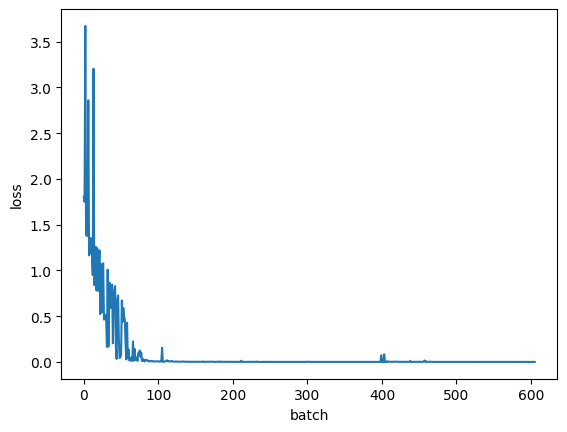

In [12]:
plt.plot(losses)
plt.xlabel('batch')
plt.ylabel('loss')

In [15]:
def get_IST(string):
    tokens = tokenizer.encode(string).unsqueeze(0).type(torch.LongTensor).to(fabric.device)
    x = LLamaModel(tokens)[1]
    x = IST_generator(x)
    return x[:,-1,:]

In [16]:
import generate
out = generate.generate(model=LLamaModel, 
                  idx=tokenizer.encode('').type(torch.LongTensor).to(fabric.device), 
                  max_new_tokens=200, 
                  max_seq_length=400,top_k=1, internal_state_tokens=get_IST('What are the three primary colors?').type(torch.bfloat16))[0]

print(tokenizer.decode(out))
